In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import torch
# import seaborn as sns

from gglm.glm.mmdglm import MMDGLM
# from gglm.cnncritic import MMDCritic
from sptr.sptr import SpikeTrain
from gglm.utils import shift_array
from kernel.fun import KernelFun
from kernel.rect import KernelRect

%load_ext autoreload
%autoreload 2

In [2]:
npz = np.load('/home/diego/python/generative-glm/cool_stuff/reliability.npz')
t, r_te, r_fr, mask_spikes_te, mask_spikes_fr  = npz['t'], npz['r_te'], npz['r_fr'], npz['mask_spikes_te'], npz['mask_spikes_fr']

u_te, u_fr = npz['u_te'], npz['u_fr']

stim = npz['stim']
u0_ml, tbins_kappa, coefs_kappa = npz['glm_u0'], npz['glm_tbins_kappa'], npz['glm_coefs_kappa']
tbins_eta, coefs_eta = npz['glm_tbins_eta'], npz['glm_coefs_eta']

dt = t[1]

n_batch_te = mask_spikes_te.shape[1]
n_batch_fr = mask_spikes_fr.shape[1]

st_te = SpikeTrain(t, mask_spikes_te)
st_fr = SpikeTrain(t, mask_spikes_fr)

mask_spikes = np.concatenate((mask_spikes_te, mask_spikes_fr), axis=1)
n_spikes_te = np.sum(mask_spikes_te, 0)
n_spikes_fr = np.sum(mask_spikes_fr, 0)
# mask_spikes_te = torch.from_numpy(mask_spikes_te)
mask_spikes_te_torch = torch.from_numpy(mask_spikes_te)
mask_spikes = torch.from_numpy(mask_spikes).double()
# y = np.concatenate((np.ones(mask_spikes_te.shape[1]), np.zeros(mask_spikes_fr.shape[1])))
y = torch.cat((torch.ones(n_batch_te), torch.zeros(n_batch_fr))).double()
u = torch.from_numpy(np.concatenate((u_te, u_fr), axis=1)).double()
r = torch.from_numpy(np.concatenate((r_te, r_fr), axis=1)).double()

ms = 1

In [3]:
# def distance(r, mask_spikes, y):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
#     n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
#     r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)
        
#     norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
#     norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
#     mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
#     d = (norm2_te + norm2_fr - 2 * mean_dot)
#     return d

#         mean_dot += torch.sum(torch.sum(_r_te_ii * r_fr, 0) / (torch.norm(_r_te_ii, dim=0)**2 + torch.norm(r_fr, dim=0)**2), 0)

# def kernel(r1_i, r2):
#     return torch.sum(r1_i * r2, 0)

# def kernel(r1_i, r2):
#     sum_r1 = torch.sum(r1_i, 0)
#     sum_r2 = torch.sum(r2, 0)
#     return sum_r1 * sum_r2

# def kernel(r1_i, r2):
#     sum_r1 = torch.sum(r1_i**2, 0)
#     sum_r2 = torch.sum(r2**2, 0)
#     return sum_r1 * sum_r2

# def kernel(r1_i, r2):
#     sum_r1 = torch.sum(torch.exp(r1_i), 0)
#     sum_r2 = torch.sum(torch.exp(r2), 0)
#     return sum_r1 * sum_r2

# def kernel(r1_i, r2):
#     return torch.sum(r1_i**2 * r2**2, 0)

# def kernel_rel(r1_i, r2):
#     return torch.sum(r1_i * r2, 0) / (torch.norm(r1_i, dim=0)**2 + torch.norm(r2, dim=0)**2)

# def kernel(r1_i, r2, mask_spikes_te):
#     sum_r1 = torch.sum(r1_i[mask_spikes_te, :], 0)
#     sum_r2 = torch.sum(r2[mask_spikes_te, :], 0)
#     return sum_r1 * sum_r2

def kernel(r1_i, r2):
    dot = torch.exp(-torch.sum((r1_i - r2)**2, 0) / 10)
    return dot

def distance(r, mask_spikes, y):
    r_te, r_fr = r[:, y == 1], r[:, y == 0]
    mask_spikes_te, mask_spikes_fr = mask_spikes[:, y == 1].bool(), mask_spikes[:, y == 0].bool()
#     mask_spikes_te, mask_spikes_fr = torch.any(mask_spikes_te, dim=1), torch.any(mask_spikes_fr, dim=1)
#     r_te, r_fr = r_te[mask_spikes_te, :], r_te[mask_spikes_fr, :]

    r_te[~mask_spikes_te] = 0
    r_fr[~mask_spikes_fr] = 0
    r_te = r_te / torch.sum(mask_spikes_te, 0)#[None, :]
    r_fr = r_fr / torch.sum(mask_spikes_fr, 0)#[None, :]
    
    n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
    norm2_te, norm2_fr, mean_dot = 0, 0, 0
    for ii in range(n_batch_te):
        _r_te_ii = r_te[:, ii:ii + 1]
        _r_te = r_te[:, ii + 1:]
        _r_fr_ii = r_fr[:, ii:ii + 1]
        _r_fr = r_fr[:, ii + 1:]
        
        norm2_te += torch.sum(kernel(_r_te_ii, _r_te), 0)
        norm2_fr += torch.sum(kernel(_r_fr_ii, _r_fr), 0)
        mean_dot += torch.sum(kernel(_r_te_ii, r_fr), 0)
        
    norm2_te /= (n_batch_te * (n_batch_te - 1) / 2)
    norm2_fr /= (n_batch_fr * (n_batch_fr - 1) / 2)
    mean_dot /= (n_batch_te * n_batch_fr)
    d = norm2_te + norm2_fr - 2 * mean_dot

    return d

# def distance(r, mask_spikes, y):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
#     mask = mask_spikes[:, y == 0]
#     mask = torch.any(mask.bool(), dim=1)
    
#     d = -torch.sum(r_fr[mask, :])

#     return d

# def distance(r, mask_spikes, y):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
    
#     n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
#     norm2_te, norm2_fr, mean_dot = 0, 0, 0
#     for ii in range(n_batch_te):
#         _r_te_ii = r_te[:, ii:ii + 1]
#         _r_te = r_te[:, ii + 1:]
#         _r_fr_ii = r_fr[:, ii:ii + 1]
#         _r_fr = r_fr[:, ii + 1:]
        
#         norm2_te += torch.sum(kernel(_r_te_ii, _r_te), 0)
#         norm2_fr += torch.sum(kernel(_r_fr_ii, _r_fr), 0)
#         mean_dot += torch.sum(kernel(_r_te_ii, r_fr), 0)
    
# #         sd = 1e0
# #         norm2_te += torch.sum(torch.exp(-torch.sum((_r_te_ii - _r_te)**2, 0) / sd), 0)
# #         norm2_fr += torch.sum(torch.exp(-torch.sum((_r_fr_ii - _r_fr)**2, 0) / sd), 0)
# #         mean_dot += torch.sum(torch.exp(-torch.sum((_r_te_ii - r_fr)**2, 0) / sd), 0)
        
#     norm2_te /= (n_batch_te * (n_batch_te - 1) / 2)
#     norm2_fr /= (n_batch_fr * (n_batch_fr - 1) / 2)
#     mean_dot /= (n_batch_te * n_batch_fr)
#     d = norm2_te + norm2_fr - 2 * mean_dot

# #     r_mean_te, r_mean_fr = torch.mean(r_te, 1), torch.mean(r_fr, 1)    
# #     d = torch.sum((r_mean_te - r_mean_fr)**2)
# #     d = torch.sum((r_mean_te**2 - r_mean_fr**2)**2)
# #     d = torch.sum((torch.exp(r_mean_te) - torch.exp(r_mean_fr))**2)
# #     d = torch.exp(-torch.sum((r_mean_te - r_mean_fr)**2) / 1e3)

#     return d

# def distance(r, mask_spikes, y):
#     r_te, r_fr = r[:, y == 1], r[:, y == 0]
#     mask_spikes_te, mask_spikes_fr = mask_spikes[:, y == 1].bool(), mask_spikes[:, y == 0].bool()
#     n_batch_te, n_batch_fr = r_te.shape[1], r_fr.shape[1]
#     mask = torch.any(mask_spikes_te, 1)
#     r_te[~mask, :] = 0
#     r_fr[~mask, :] = 0
#     r_sum_te, r_sum_fr = torch.sum(r_te, 1), torch.sum(r_fr, 1)
#     norm2_te = (torch.sum(r_sum_te**2) - torch.sum(r_te**2)) / (n_batch_te * (n_batch_te - 1))
#     norm2_fr = (torch.sum(r_sum_fr**2) - torch.sum(r_fr**2)) / (n_batch_fr * (n_batch_fr - 1))
#     mean_dot = torch.sum(r_sum_te * r_sum_fr, 0) / (n_batch_te * n_batch_fr)
#     d = (norm2_te + norm2_fr - 2 * mean_dot)
#     return d

 epoch 124 of 125 loss 6532.4505

Text(0.5, 0, '# spikes')

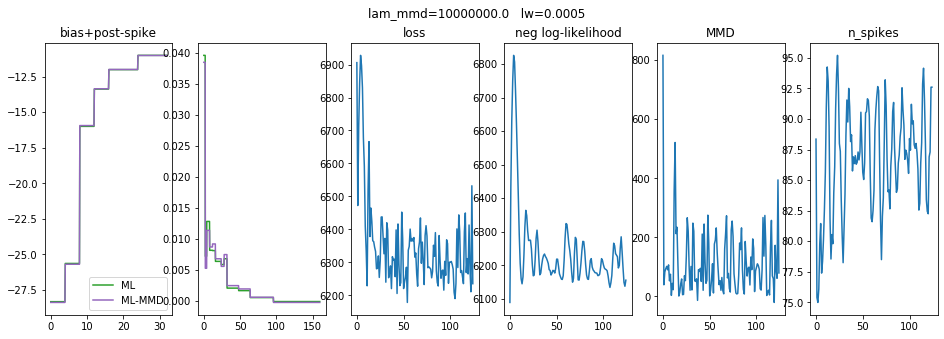

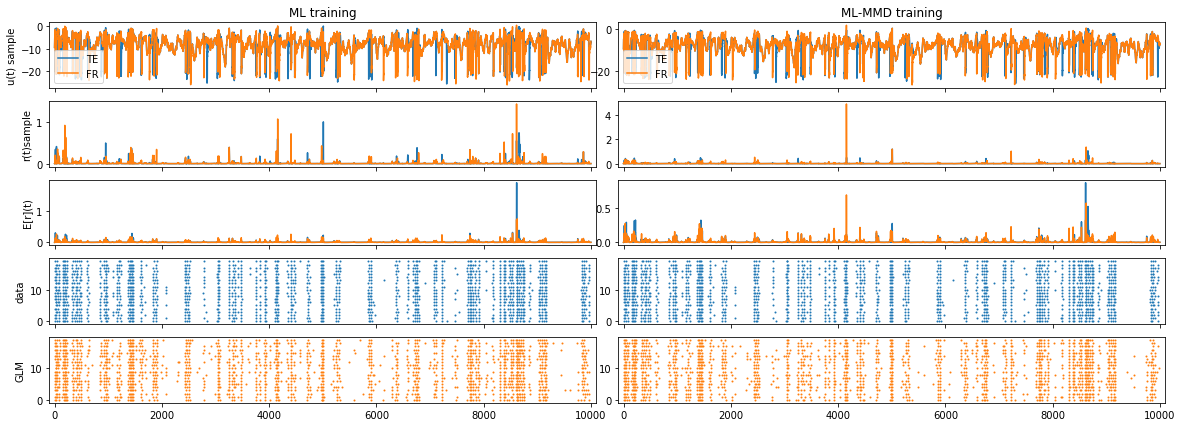

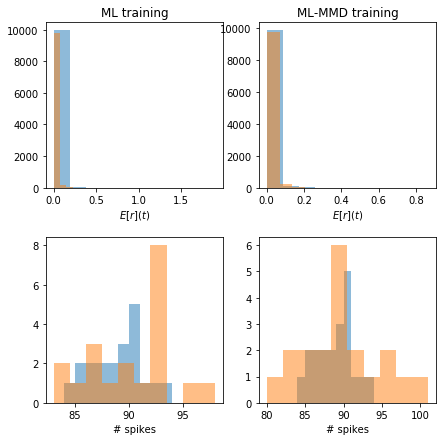

In [5]:
# lam_mmd, num_epochs, lr, non_linearity = 0, 50, 5e-4, 'exp' # no kernel
# lam_mmd, num_epochs, lr, non_linearity = 1e3, 100, 1e-3, 'exp' # match mean(r, 1)
# lam_mmd, num_epochs, lr, non_linearity = 1e2, 175, 5e-4, 'exp' # match mean(r, 0)
# lam_mmd, num_epochs, lr, non_linearity = 1e2, 50, 5e-4, 'exp' # match mean(r**2, 0)
lam_mmd, num_epochs, lr, non_linearity = 1e7, 125, 5e-4, 'exp' 
optim_pars = dict(lr=lr, betas=(0.9, 0.999))

kappa_ml = KernelRect(tbins=tbins_kappa, coefs=coefs_kappa)
eta_ml = KernelRect(tbins=tbins_eta, coefs=coefs_eta)

wglm = MMDGLM(u0=float(u0_ml), kappa=kappa_ml.copy(), eta=eta_ml.copy(), non_linearity=non_linearity)

loss, mmd, n_spikes = wglm.train(t, mask_spikes_te_torch, y, distance, stim=stim, lam_mmd=lam_mmd, optim_pars=optim_pars, num_epochs=num_epochs, 
                                 n_batch_fr=n_batch_fr, verbose=True, mmd_kwargs=dict(sd=1e10))
loss, mmd, n_spikes = np.array(loss), np.array(mmd), np.array(n_spikes)

u_new_fr, r_new_fr, mask_spikes_new_fr = wglm.sample(t, stim=stim)
u_new_te, r_new_te = wglm.sample_conditioned(t, mask_spikes_te, stim=stim)

st_new_fr = SpikeTrain(t, mask_spikes_new_fr)
mask_spikes_new = np.concatenate((mask_spikes_te, mask_spikes_new_fr), axis=1)
n_spikes_new_fr = np.sum(mask_spikes_new_fr, 0)
# mask_spikes_te = mask_spikes_te.numpy()
mask_spikes_new = torch.from_numpy(mask_spikes_new).double()
u_new = torch.from_numpy(np.concatenate((u_new_te, u_new_fr), axis=1)).double()
r_new = np.concatenate((r_new_te, r_new_fr), axis=1)
r_new = torch.from_numpy(r_new)

fig1, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(figsize=(16, 5), ncols=6)
fig1.suptitle('lam_mmd=' + str(lam_mmd) + '   lw=' + str(lr))
ti = np.arange(wglm.eta.support[0], wglm.eta.support[1], .1)
vals_ml = eta_ml.interpolate(ti) + u0_ml
vals = wglm.eta.interpolate(ti) + wglm.u0
ax0.plot(ti, vals_ml, color='C2', label='ML')
ax0.plot(ti, vals, color='C4', label='ML-MMD')
ax0.set_title('bias+post-spike')
ax0.legend()
ti = np.arange(wglm.kappa.support[0], wglm.kappa.support[1], .1)
vals_ml = kappa_ml.interpolate(ti)
vals = wglm.kappa.interpolate(ti)
ax1.plot(ti, vals_ml, color='C2', label='ML')
ax1.plot(ti, vals, color='C4', label='ML-MMD')
ax2.plot(loss)
ax2.set_title('loss')
ax3.plot(loss - mmd)
ax3.set_title('neg log-likelihood')
ax4.plot(mmd)
ax4.set_title('MMD')
ax5.plot(n_spikes)
ax5.set_title('n_spikes')

fig2, ((ax00, ax01), (ax10, ax11), (ax20, ax21), (ax30, ax31), (ax40, ax41)) = plt.subplots(figsize=(20, 7), nrows=5, ncols=2, 
                                                                                           sharex=True, sharey=False)
fig2.subplots_adjust(wspace=0.04)

ax00.set_title('ML training')
ax00.plot(t, u_te[:, 0], label='TE')
ax00.plot(t, u_fr[:, 0], label='FR')
ax00.legend()
ax10.plot(t, r_te[:, 0])
ax10.plot(t, r_fr[:, 0])
ax20.plot(t, np.mean(r_te, 1))
ax20.plot(t, np.mean(r_fr, 1))
st_te.plot(ax=ax30, ms=ms, color='C0')
st_fr.plot(ax=ax40, ms=ms, color='C1')
ax00.set_ylabel('u(t) sample')
ax10.set_ylabel('r(t)sample')
ax20.set_ylabel('E[r](t)')
ax30.set_ylabel('data')
ax40.set_ylabel('GLM')

ax01.set_title('ML-MMD training')
ax01.plot(t, u_new_te[:, 0], label='TE')
ax01.plot(t, u_new_fr[:, 0], label='FR')
ax01.legend()
ax11.plot(t, r_new_te[:, 0])
ax11.plot(t, r_new_fr[:, 0])
ax21.plot(t, np.mean(r_new_te, 1))
ax21.plot(t, np.mean(r_new_fr, 1))
st_te.plot(ax=ax31, ms=ms, color='C0')
st_new_fr.plot(ax=ax41, ms=ms, color='C1')

fig3, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
fig3.subplots_adjust(hspace=0.3)
ax1.hist(torch.mean(r[:, y == 1], 1), alpha=0.5)
ax1.hist(torch.mean(r[:, y == 0], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 1], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 0], 1), alpha=0.5)

ax3.hist(n_spikes_te, alpha=0.5)
ax3.hist(n_spikes_fr, alpha=0.5)
ax4.hist(n_spikes_te, alpha=0.5)
ax4.hist(n_spikes_new_fr, alpha=0.5)

ax1.set_title('ML training')
ax2.set_title('ML-MMD training')
ax1.set_xlabel('$E[r](t)$') 
ax2.set_xlabel('$E[r](t)$')
ax3.set_xlabel('# spikes')
ax4.set_xlabel('# spikes')

Text(0.5, 1.0, 'r corrs')

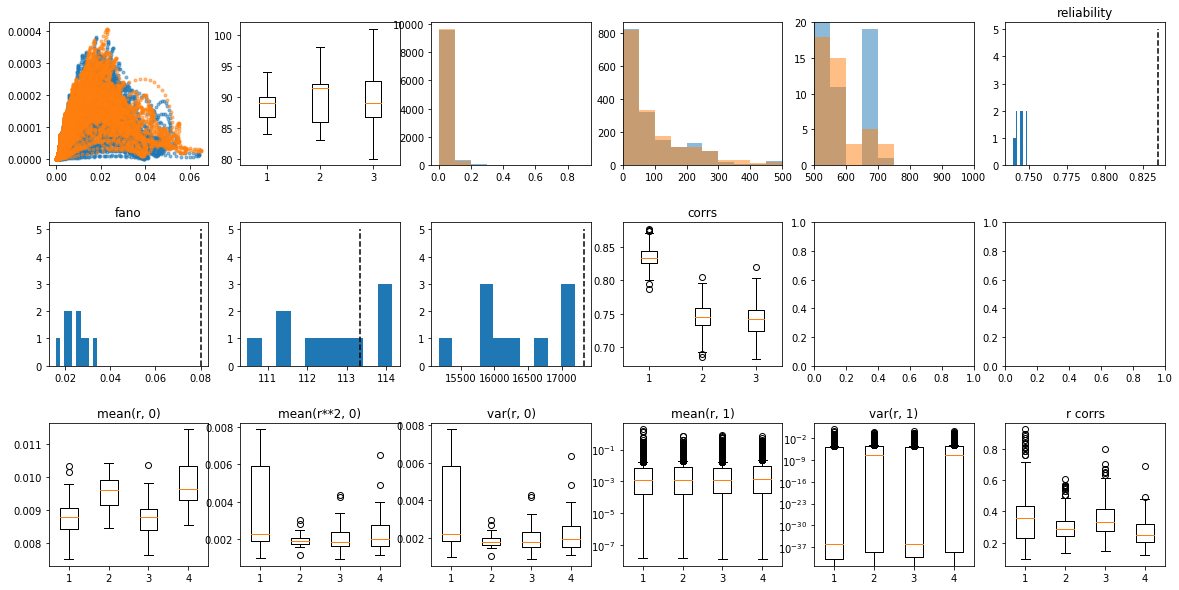

In [6]:
ker = KernelFun.gaussian_delta(10)

rel_te = st_te.reliability(ker, ker)
fano_te = np.mean(st_te.sliding_fano_factor(ker))
rels, fanos = [], []
mean_isis, var_isis = [], []
for ii in range(10):
    _u_fr, _r_fr, _mask_spikes_fr = wglm.sample(t, stim=stim)
    _st = SpikeTrain(t, _mask_spikes_fr)
    rels.append(_st.reliability(ker, ker))
    fanos.append(np.mean(_st.sliding_fano_factor(ker)))
    _isi_fr = _st.isi_distribution()
    mean_isis.append(np.mean(_isi_fr))
    var_isis.append(np.var(_isi_fr))

mean_spk_te = st_te.convolve(ker)
mean_spk_new_fr = st_new_fr.convolve(ker)
var_spk_te = np.var(mean_spk_te, 1)
var_spk_new_fr = np.var(mean_spk_new_fr, 1)
mean_spk_te = np.mean(mean_spk_te, 1)
mean_spk_fr = np.mean(mean_spk_new_fr, 1)

isi_te = st_te.isi_distribution()
mean_isi_te, var_isi_te = np.mean(isi_te), np.var(isi_te)
isi_fr = st_fr.isi_distribution()
isi_new_fr = st_new_fr.isi_distribution()

fig, ((ax1, ax2, ax3, ax4, ax5, ax6), (ax7, ax8, ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16, ax17, ax18)) = plt.subplots(figsize=(20, 10), nrows=3, ncols=6)
fig.subplots_adjust(hspace=0.4)
ax1.plot(mean_spk_te, var_spk_te, '.', alpha=0.5)
ax1.plot(mean_spk_fr, var_spk_new_fr, '.', alpha=0.5)

m1, m2, m3 = np.sum(mask_spikes_te, 0), np.sum(mask_spikes_fr, 0), np.sum(mask_spikes_new_fr, 0)
ax2.boxplot(x=(m1, m2, m3));
m1, m2, m3 = np.mean(mask_spikes_te, 1), np.mean(mask_spikes_fr, 1), np.mean(mask_spikes_new_fr, 1)
bins = np.arange(0, 1, .1)
ax3.hist(m1, alpha=0.5, bins=bins);
# ax3.hist(m2, alpha=0.5, bins=bins);
ax3.hist(m3, alpha=0.5, bins=bins);

bins = np.arange(0, 1050, 50)
ax4.hist(isi_te, bins=bins, alpha=0.5);
# ax4.hist(isi_fr, bins=bins, alpha=0.5);
ax4.hist(isi_new_fr, bins=bins, alpha=0.5);
ax4.set_xlim(0, 500)
ax5.hist(isi_te, bins=bins, alpha=0.5);
# ax5.hist(isi_fr, bins=bins, alpha=0.5);
ax5.hist(isi_new_fr, bins=bins, alpha=0.5);
ax5.set_xlim(500, 1000)
ax5.set_ylim(0, 20)

ax6.hist(rels)
ax6.plot([rel_te, rel_te], [0, 5], 'k--')
ax6.set_title('reliability')
ax7.hist(fanos)
ax7.set_title('fano')
ax7.plot([fano_te, fano_te], [0, 5], 'k--')

ax8.hist(mean_isis)
ax8.plot([mean_isi_te, mean_isi_te], [0, 5], 'k--')
ax9.hist(var_isis)
ax9.plot([var_isi_te, var_isi_te], [0, 5], 'k--')

corrs_te = st_te.cosine_matrix(st_te, ker, ker)[np.triu_indices(st_te.nsweeps, k=1)]
corrs_fr = st_fr.cosine_matrix(st_fr, ker, ker)[np.triu_indices(st_fr.nsweeps, k=1)]
corrs_new_fr = st_new_fr.cosine_matrix(st_new_fr, ker, ker)[np.triu_indices(st_new_fr.nsweeps, k=1)]
ax10.boxplot(x=(corrs_te, corrs_fr, corrs_new_fr))
ax10.set_title('corrs')

r1, r2, r3, r4 = np.mean(r_te, 0), np.mean(r_fr, 0), np.mean(r_new_te, 0), np.mean(r_new_fr, 0)
ax13.boxplot(x=(r1, r2, r3, r4))
ax13.set_title('mean(r, 0)')

r1, r2, r3, r4 = np.mean(r_te**2, 0), np.mean(r_fr**2, 0), np.mean(r_new_te**2, 0), np.mean(r_new_fr**2, 0)
ax14.boxplot(x=(r1, r2, r3, r4))
ax14.set_title('mean(r**2, 0)')

r1, r2, r3, r4 = np.var(r_te, 0), np.var(r_fr, 0), np.var(r_new_te, 0), np.var(r_new_fr, 0)
ax15.boxplot(x=(r1, r2, r3, r4))
ax15.set_title('var(r, 0)')
# ax14.set_yscale('log')

r1, r2, r3, r4 = np.mean(r_te, 1), np.mean(r_fr, 1), np.mean(r_new_te, 1), np.mean(r_new_fr, 1)
ax16.boxplot(x=(r1, r2, r3, r4))
ax16.set_title('mean(r, 1)')
ax16.set_yscale('log')

r1, r2, r3, r4 = np.var(r_te, 1), np.var(r_fr, 1), np.var(r_new_te, 1), np.var(r_new_fr, 1)
ax17.boxplot(x=(r1, r2, r3, r4))
ax17.set_title('var(r, 1)')
ax17.set_yscale('log')

corr_te, corr_fr, corr_new_te, corr_new_fr = [], [], [], []
norm_te = np.sum(r_te**2, 0)**0.5
norm_fr = np.sum(r_fr**2, 0)**0.5
norm_new_te = np.sum(r_new_te**2, 0)**0.5
norm_new_fr = np.sum(r_new_fr**2, 0)**0.5
for ii in range(r_te.shape[1] - 1):
    corr_te.append(np.sum(r_te[:, ii:ii + 1] * r_te[:, ii + 1:], 0) / (norm_te[ii] * norm_te[ii + 1:]))
    corr_fr.append(np.sum(r_fr[:, ii:ii + 1] * r_fr[:, ii + 1:], 0) / (norm_fr[ii] * norm_fr[ii + 1:]))
    corr_new_te.append(np.sum(r_new_te[:, ii:ii + 1] * r_new_te[:, ii + 1:], 0) / (norm_new_te[ii] * norm_new_te[ii + 1:]))
    corr_new_fr.append(np.sum(r_new_fr[:, ii:ii + 1] * r_new_fr[:, ii + 1:], 0) / (norm_new_fr[ii] * norm_new_fr[ii + 1:]))

corr_te = np.concatenate((corr_te))
corr_fr = np.concatenate((corr_fr))
corr_new_te = np.concatenate((corr_new_te))
corr_new_fr = np.concatenate((corr_new_fr))
ax18.boxplot(x=(corr_te, corr_fr, corr_new_te, corr_new_fr))
ax18.set_title('r corrs')

array([0.59510678, 0.57558773, 0.68800282, 0.55551622, 0.75764327,
       0.64775242, 0.68931743, 0.52895976, 0.46839177, 0.3887454 ,
       0.60438675, 0.61802738, 0.63362074, 0.42853239, 0.50000758,
       0.74123035, 0.58766323, 0.58038811, 0.53835232, 0.52070751,
       0.59141163, 0.67203665, 0.71135992, 0.82594915, 0.79525704,
       0.52852543, 0.43297907, 0.38577286, 0.42058564, 0.66905429,
       0.74482168, 0.33736776, 0.46094719, 0.74156565, 0.63191972,
       0.60529258, 0.61190191, 0.52984879, 0.8084078 , 0.63106913,
       0.54688608, 0.61396905, 0.84399392, 0.70836417, 0.61433158,
       0.69277522, 0.55224708, 0.64210637, 0.75170879, 0.7522546 ,
       0.65061061, 0.46811385, 0.63838215, 0.85039791, 0.56077661,
       0.75587075, 0.66329981, 0.69553027, 0.42759356, 0.62257615,
       0.46667167, 0.45715025, 0.61605175, 0.65614092, 0.53381803,
       0.41636979, 0.79486468, 0.76628453, 0.71046562, 0.54041614,
       0.6712464 , 0.68169632, 0.77459254, 0.80521226, 0.66739

In [13]:
ker1, ker2 = KernelRect.kistler_kernels(2, 1)
print(st_te.reliability(ker1, ker2), st_fr.reliability(ker1, ker2), st_new_fr.reliability(ker1, ker2))

0.34784856879039694 0.18874773139745918 0.16020383788518192


In [46]:
import os
name = '/home/diego/Dropbox/generative_glm/figures/mmd_fixed_freq_fit_' + str(lam_mmd) + '_' + str(num_epochs)
fig1.savefig(name + '1.pdf', transparent=True)
fig2.savefig(name + '2.pdf', transparent=True)
fig3.savefig(name + '3.pdf', transparent=True)
os.system('pdfunite ' + name + '*.pdf ' + name + '.pdf')

0

In [40]:
os.system('pdfunite ' + name + '*.pdf ' + name + '.pdf')

0

In [38]:
'pdfunite ' + name + '*.pdf ' + name + '.pdf'

'pdfunite /home/diego/Dropbox/generative_glm/figures/mmd_divergent_fr_fit_0.1*.pdf /home/diego/Dropbox/generative_glm/figures/mmd_divergent_fr_fit_0.1.pdf'

(0.004517, 0.004518)

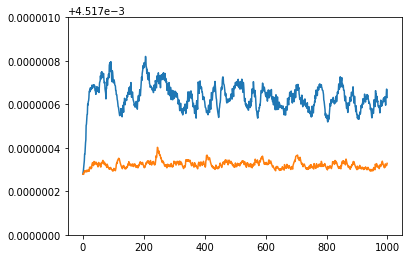

In [38]:
plt.plot(t, np.mean(r_new_te, 1))
plt.plot(t, np.mean(r_new_fr, 1))
plt.ylim(4.517e-3, 4.518e-3)

In [29]:
np.max(r_new_te)

0.004520379645401455

(array([241., 347., 163.,  95.,  55.,  50.,  20.,  20.,   6.,   3.]),
 array([0.01248375, 0.01402818, 0.01557262, 0.01711705, 0.01866149,
        0.02020592, 0.02175036, 0.02329479, 0.02483923, 0.02638366,
        0.0279281 ]),
 <a list of 10 Patch objects>)

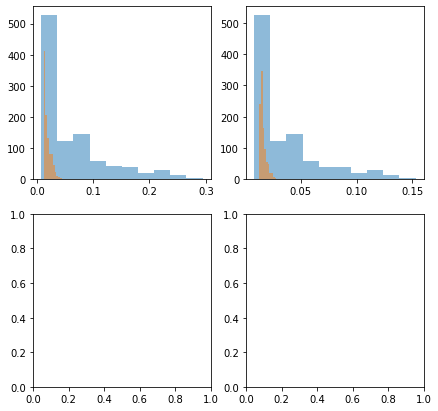

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(7, 7), nrows=2, ncols=2)
ax1.hist(torch.mean(r[:, y == 1], 1), alpha=0.5)
ax1.hist(torch.mean(r[:, y == 0], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 1], 1), alpha=0.5)
ax2.hist(torch.mean(r_new[:, y == 0], 1), alpha=0.5)
# ax1.hist(output0[y == 0], alpha=0.5)
# ax2.hist(output[y == 1], alpha=0.5)
# ax2.hist(output[y == 0], alpha=0.5)

In [20]:
r.shape

torch.Size([1000, 200])